<div class="alert alert-block" style = "background-color: black">
    <p><b><font size="+3" color="orange">Data Cleaning & Preparation</font></b></p>
    <p><b><font size="+1" color="white">Online Shopping Data</font></b></p>
    </div>

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_columns',None)
pd.options.display.max_colwidth = 500
pd.options.display.max_rows = 100
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
plt.rcParams.update({'font.size':14}) #sets global font size
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score



## Step 1: Review background information


### Information on data collection 


We unfortunately don't know a whole lot about how the data were collected. All that we do know is from the [UCI Machine Learning repository]((https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset#)) itself and the paper written by Sakar et al.'s 2009 [paper](https://link.springer.com/article/10.1007/s00521-018-3523-0) titled 'Real-time prediction of online shoppers' purchasing intention using multilayer perceptron and LSTM recurrent neural networks'. 


### Data dictionary

The features (in terms of the cleaned columns names) for each user session include a set of variables describing the number and type of pages each user visited in their session, and the amount of time they spend on each type of page:

- `Administrative`: the number of administrative-type pages that the user visited during the session.

- `Administrative_Duration`: the length of time (in seconds) that the user spent on administrative pages during their session.

- `Informational`: the number of informational-type pages that the user visited during the session.

- `Informational_Duration`: the length of time (in seconds) that the user spent on informational pages during their session.

- `ProductRelated`: the number of product-related-type pages that the user visited during the session.

- `ProductRelated_Duration`: the length of time (in seconds) that the user spent on product-related pages during their session.

Next, there are a set of features collected from Google Analytics. 

- `BounceRates`: 
    - Definition: Bounce rate represents the percentage of visitors who land on a specific page of the website and leave (or "bounce") without visiting any other pages.
    - Interpretation: A high bounce rate can suggest that the landing page didn’t meet the visitor’s expectations or that they didn’t find the page relevant, useful, or engaging enough to continue browsing.
    - In Online Shopping: A high bounce rate on a product page may indicate that customers didn’t find the product appealing, the price might be too high, or the content didn’t meet their needs. For an e-commerce homepage, it could indicate a disconnect between marketing and the landing page.


- `ExitRates`:  
    - Definition: Exit rate is the percentage of pageviews for which a particular page was the last page in the session (i.e., the user exited the website from this page).
    - Interpretation: A high exit rate can show that visitors frequently leave the site from that specific page, but this is not necessarily negative. Unlike the bounce rate, it considers sessions in which visitors may have viewed multiple pages before leaving.
    - In Online Shopping: For example, a high exit rate on a checkout page might indicate abandonment issues (e.g., unexpected costs, complex checkout process). But a high exit rate on an order confirmation page is normal since it’s typically the last page a user views after completing a purchase.


- `PageValues`: the average page value of the pages visited during the session. The *page value* for a web page gives an idea of how much each page contributes to the site's revenue. 

- `OperatingSystems`: the operating system that the user was using for the session. The operating systems are coded as integers.

- `Browser`: the web browser that the user was using for the session. The browsers are coded as integers.

- `Region`: the geographic region in which the user is located for their session. The regions are coded as integers.

- `TrafficType`: the source of the referral for the session (how did the user arrive at the site?), examples include an advertisement banner, an SMS link, direct URL. The traffic types are coded as integers.

- `VisitorType`: a categorical variable that specifies whether the session corresponded to a `"New_Visitor"`, a `"Returning_Visitor"`, or `"Other"` (whatever "other" means). 

Then there are also several features corresponding to the date.

- `SpecialDay`: a numeric value between 0 and 1 indicating how closeness the site visiting time is to a "special day" (such as Mother's day, Valentine's day), in which the sessions are - hypothetically - more likely to be finalized with a transaction. The value of this attribute is determined by considering the dynamics of e-commerce such as the duration between the order date and delivery date. For example, for Valentine’s day, `special_day` takes a nonzero value between February 2 and February 12, achieving the maximum value of 1 on February 8 (6 days before Valentine's day).

- `Month`: the month in which the session took place.

- `Weekend`: a binary variable corresponding to whether the session occurred on a weekend or a weekday.

Finally, there is the response variable that we are interested in predicting:

- `Revenue`: the **response variable** corresponding to whether a purchase was made during the session. (We will change the name of this feature to `purchase` below.)



### Answering questions about the background information

In this section, we will go through the recommended background information questions from the Data Cleaning chapter.

- *What does each variable measure?* Most of the information in the data dictionary is fairly self-explanatory. We did some Googling to understand the Google Analytics variables, many of which involve aggregate measurements across many all sessions (which was confusing because they are different numbers for each session). It turns out that each page has an associated "bounce rate', for example, and an individual *session's* bounce rate corresponds to the *average* bounce rate across *all pages* that were visited in the session (similarly for the 'exit rate' and "page values" etc). Some useful information can be found [here](https://support.google.com/analytics/answer/2695658?hl=en&ref_topic=6156780).

- *How was the data collected?* We unfortunately don't have a whole lot of information about where the data came from, and which online shop it corresponds to. (We emailed the authors of the data requesting additional background information and did not hear back.)

- *What are the observational units?* The observational units are the individual user sessions.

- *Is the data relevant to my project?* Since we defined our project goal narrowly as generating predictions for sessions to the same e-commerce store in the years immediately following the period covered by the data, the data is relevant to our project. But since we know so little about the data and even what type of e-commerce store it corresponds to, the data is not particularly relevant outside of this very narrow scope. 



### __Step 2. Load the data__

In [2]:
shopping_orig = pd.read_csv('../../vds-book-supplementary/python/online_shopping/data/online_shoppers_intention.csv')
shopping_orig.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


#### $\color {blue} {\text{1. Why are there negative duration values?}}$

**Examine the sape of the data**

In [3]:
shopping_orig.shape

(12330, 18)

#### __Step 3. Examine the data__
In this section we identify the common messy data traits to take any cleaning action items

#### __3.1. Invalid Values__
Recall that we saw some negative values in the `Duration` columns, lets explore other sections of the data

In [4]:
shopping_orig.sample(20, random_state=200)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
5962,3.0,13.000000,1.0,0.0,51.0,4651.612222,0.004156,0.020606,0.000000,0.0,Jul,2,4,3,4,Returning_Visitor,False,False
8949,0.0,0.000000,0.0,0.0,1.0,11.000000,0.000000,0.100000,0.000000,0.0,Dec,1,1,3,1,Returning_Visitor,False,False
8103,1.0,49.500000,0.0,0.0,14.0,207.541667,0.000000,0.015385,0.000000,0.0,Dec,2,4,1,2,New_Visitor,False,False
8230,7.0,82.766667,1.0,47.0,391.0,15025.233020,0.001515,0.010141,1.271407,0.0,Nov,2,2,1,1,Returning_Visitor,False,False
11941,3.0,17.000000,0.0,0.0,62.0,1493.353846,0.009524,0.040317,0.000000,0.0,Dec,2,2,1,2,Returning_Visitor,False,False
4692,0.0,0.000000,0.0,0.0,3.0,0.000000,0.200000,0.200000,0.000000,0.6,May,2,2,6,3,Returning_Visitor,False,False
11642,7.0,93.500000,0.0,0.0,101.0,2186.145833,0.000000,0.004808,32.139222,0.0,Nov,2,2,1,1,Returning_Visitor,False,False
10373,1.0,11.000000,0.0,0.0,26.0,651.066667,0.000000,0.016667,0.000000,0.0,Nov,4,2,1,3,Returning_Visitor,False,False
7688,0.0,0.000000,0.0,0.0,6.0,31.000000,0.000000,0.033333,0.000000,0.0,Oct,2,5,1,1,Returning_Visitor,False,False
3674,6.0,93.500000,0.0,0.0,23.0,251.333333,0.000000,0.013768,0.000000,0.0,May,2,2,3,3,New_Visitor,False,False


Nothing seems odd in this random sample selection, lets explore individual variables

#### __Numeric Variables__
To explore the validity of the numeric values, we look at the descriptive statistics of the variables

In [5]:
shopping_orig.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.317798,80.906176,0.503979,34.506387,31.763884,1196.037057,0.022152,0.043003,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.322754,176.860432,1.270701,140.825479,44.490339,1914.372511,0.048427,0.048527,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,185.000000,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,8.000000,0.000000,0.000000,18.000000,599.766190,0.003119,0.025124,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.500000,0.000000,0.000000,38.000000,1466.479902,0.016684,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


- The three duration columns (administrative, informational and product related) have a minimum value of -1.0. 
- A few other columns like `OperatingSystems`, `Browser`, `Region` and `TrafficType` may need to be coded as categorical variables. 
- This seems to be the only cases of invalid data in the dataset and will be addressed accordingly
- To see how prevalent these negative values are in the dataset, we could make a count of such cases

In [6]:
shopping_orig[['Administrative_Duration','Informational_Duration','ProductRelated_Duration']].apply(lambda x:x== -1).sum()

Administrative_Duration    33
Informational_Duration     33
ProductRelated_Duration    33
dtype: int64

Lets find those instances

In [7]:
shopping_orig[['Administrative_Duration','Informational_Duration','ProductRelated_Duration']].query('Administrative_Duration == -1')

,Administrative_Duration,Informational_Duration,ProductRelated_Duration
2,-1.0,-1.0,-1.0
6,-1.0,-1.0,-1.0
7,-1.0,-1.0,-1.0
16,-1.0,-1.0,-1.0
21,-1.0,-1.0,-1.0
24,-1.0,-1.0,-1.0
49,-1.0,-1.0,-1.0
50,-1.0,-1.0,-1.0
64,-1.0,-1.0,-1.0
132,-1.0,-1.0,-1.0


As you can see, there are 33 cases of negative durations across the entire dataset. Also worthy of note is the fact that a negative instance goes across board to the other two duration columns. Since it doesnt make sense to have negative duration values, we need to decide on a course of action that would not impact our algorithm nor analysis.Could this be an artifact? **Take Action** 

#### $\color {blue} {\text{2. Cleanup Action - Replace them with missing values}}$

#### __Visualize underlying distribution of Numeric Features__

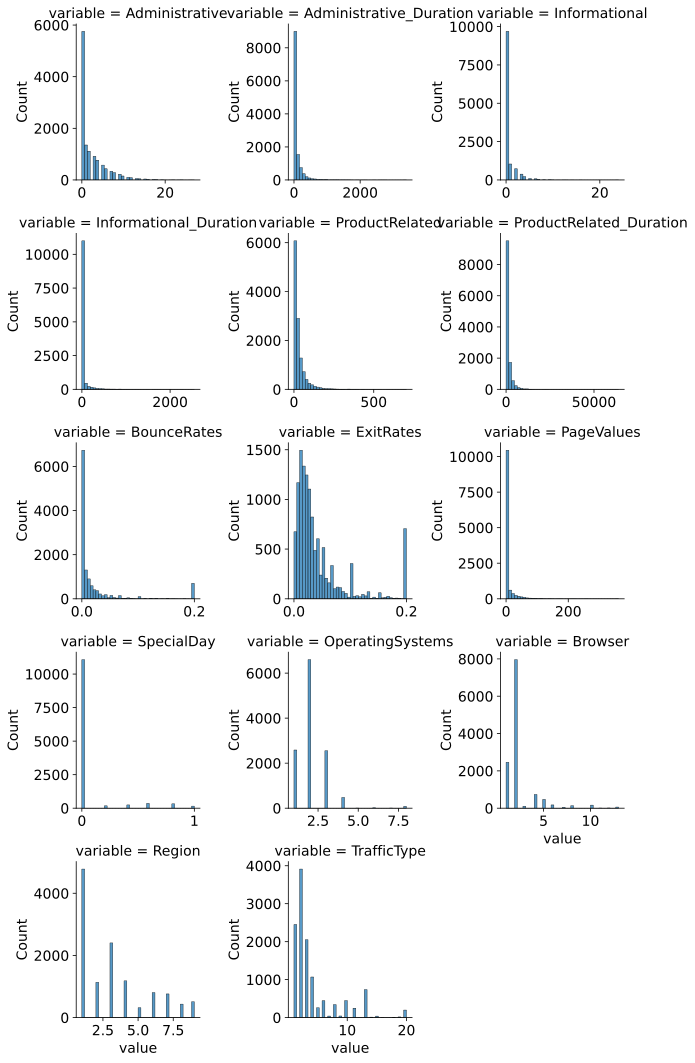

In [8]:
shopping_orig_numeric = shopping_orig.select_dtypes(include=['float64','int64']).melt()
#Create a FacetGrid of 3by3 matrix where each plot does not share an x and y axis
g = sb.FacetGrid(shopping_orig_numeric, col='variable', col_wrap=3, sharex=False, sharey=False)
g.map(sb.histplot, 'value', bins=40);

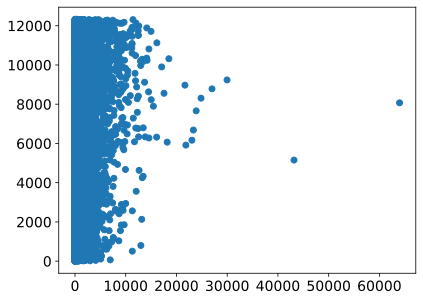

In [9]:
plt.scatter(shopping_orig["ProductRelated_Duration"],list(shopping_orig.index))

The distribution here looks skewed to the right and may need to be standardized or nomarlized as a logistic regression assumes the data follows a normal distribution. There are also some outliers in the data as shown across the plots. Also, variance exists in the data. As such data transformation would be required to reduce the scale variance. 

#### $\color {blue} {\text{3. Cleanup Action - Transform the affected predictors to log transform values}}$
Here's why this is needed:
- Reduce Skewness - This makes the distribution more symmetric and closer to normal shape
- Handle Outliers - Log transformation reduce impact of outliers since this compresses large values more than small ones improving model performance and stability
- Achieve Linearity - Non-linear Relationships between predictor and target may be made linear through log transformation making it easier to model using linear techniques
- Scale Variance - Log transformation can reduce the variance of data with high range of values making them more comparable improving model learning and performance
- Interpretability of Regression Models - A log-transformed predictor allows interporeting coeeficients in terms of percentage changes rather than absolute changes

#### __Categorical Variables__
Next we will look at the unique values of the categorical variables (xterized as objects)

In [10]:
#show the unique values in each categorical columns
for col in shopping_orig.select_dtypes(include=['object']):
    print (shopping_orig[col].value_counts())

Month
May     3364
Nov     2998
Mar     1907
Dec     1727
Oct      549
Sep      448
Aug      433
Jul      432
June     288
Feb      184
Name: count, dtype: int64
VisitorType
Returning_Visitor    10551
New_Visitor           1694
Other                   85
Name: count, dtype: int64


The default categorical variables are `Month` and `VisitorType`. 

- It can be seen from the month data that there are no observations recorded for the months of january and April.
#### $\color {blue} {\text{3. Why is January and April Data Missing?}}$

- It is also not known what it means for a visitor type to be `Other`.There are only 85 instnaces of it. It is either a visitor is a `New_Visitor` or `Returning_Visitor`.

#### $\color {blue} {\text{4. Preprocessing Action - Convert Visitor type to a binary variable}}$

Other numeric variables that may be categorical are - `Region`, `TrafficType`, `OperatingSystem`, `Browser`. Let's take a closer look at them


In [11]:
for col in shopping_orig[['Region','TrafficType','Browser', 'OperatingSystems']]:
    print(shopping_orig[col].value_counts())

Region
1    4780
3    2403
4    1182
2    1136
6     805
7     761
9     511
8     434
5     318
Name: count, dtype: int64
TrafficType
2     3913
1     2451
3     2052
4     1069
13     738
10     450
6      444
8      343
5      260
11     247
20     198
9       42
7       40
15      38
19      17
14      13
18      10
16       3
12       1
17       1
Name: count, dtype: int64
Browser
2     7961
1     2462
4      736
5      467
6      174
10     163
8      135
3      105
13      61
7       49
12      10
11       6
9        1
Name: count, dtype: int64
OperatingSystems
2    6601
1    2585
3    2555
4     478
8      79
6      19
7       7
5       6
Name: count, dtype: int64


From these results, we find that there are some levels with very few observations. We can use a threshold of 50 observations minimum in a category and those less than that can all be grouped into one category for the training set. For the validation and test sets, the same categories created for the training set can also be created for them.

#### __Understanding TrafficType__
In the context of online shopping data, TrafficType likely represents the source or channel through which users arrived at the online store. Here are some possible interpretations:

    Direct Traffic: Users who typed the store’s URL directly into their browser or used a bookmark. This often represents returning visitors who know the brand.

    Organic Search: Users who arrived via a search engine (like Google or Bing) without clicking on paid ads. These users may have found the store by searching for specific products or keywords.

    Paid Search: Users who came through paid advertisements on search engines. This can include traffic from pay-per-click (PPC) campaigns.

    Referral Traffic: Users who arrived from other websites, such as affiliate sites, blogs, or partnerships. This indicates they clicked a link on a different site.

    Social Media: Users who accessed the store from social media platforms like Facebook, Instagram, Twitter, etc.

    Email Marketing: Users who clicked on a link from an email campaign.

    Display Ads: Users who came through banner or display ads on various websites.

    Other Sources: This might cover any other sources that don’t fit into the above categories, such as direct app traffic or traffic from QR codes.

In your dataset, if TrafficType is represented as an integer, the numbers may correspond to these different traffic sources, but without metadata, it’s hard to determine the exact mapping. You could create hypothetical labels such as "Direct", "Organic", "Referral", etc., to make the analysis more intuitive. Additionally, it might be insightful to analyze TrafficType categories in relation to metrics like Bounce_Rate or Conversion_Rate to see if specific sources perform 

#### __3.2. MISSING VALUES__
We can count all the instances of missing values in each column

In [12]:
shopping_orig.apply(lambda x: sum(x.isnull()))

Administrative             14
Administrative_Duration    14
Informational              14
Informational_Duration     14
ProductRelated             14
ProductRelated_Duration    14
BounceRates                14
ExitRates                  14
PageValues                  0
SpecialDay                  0
Month                       0
OperatingSystems            0
Browser                     0
Region                      0
TrafficType                 0
VisitorType                 0
Weekend                     0
Revenue                     0
dtype: int64

As seen, there are only 14 cases of missing values in the affected columns above.Before deciding a course of action, we will check to see if they occur in the same rows.

In [13]:
shopping_orig[shopping_orig['Administrative'].isnull()]

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
1065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,2,2,2,1,Returning_Visitor,False,False
1132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,1,1,1,2,Returning_Visitor,False,False
1133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,2,4,5,1,Returning_Visitor,False,False
1134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,2,2,1,2,Returning_Visitor,False,False
1135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,3,2,1,1,Returning_Visitor,False,False
1136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,2,2,1,2,Returning_Visitor,False,False
1473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,2,2,1,1,Returning_Visitor,True,False
1474,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,1,1,6,1,Returning_Visitor,True,False
1475,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,2,2,3,1,Returning_Visitor,False,False
1476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,Mar,1,1,2,3,Returning_Visitor,False,False


From this table, this looks like a case of potential system failure during datat collection. These incidences all occurred in march. The webpages were accessed by different browsers from different regions with few on weekends and most on weekdays. The issue involved here is that page duration was not logged. The likely course of action to take here is to remove these records as they do not also contribute to revenue generation. 

#### $\color {blue} {\text{5. Preprocessing Action: Remove the rows with missing records}}$  

#### __3.3. Data Fromat__
The data is already in a tidy format where each row corresponds to an observation and each column corresponds to a measurement

#### __3.4. Column Names__
The column names need to be cleaned to conform with owerscore underscore separated format. A custom fnction will be witten for that purpose.

#### $\color {blue} {\text{6. Cleanup Action: Write custom function to clean faeture names}}$


#### __3.5. Variable Types__
We seek to properly define the variables as numeric and categorical. We shall print all variables to examine their types

In [14]:
shopping_orig.dtypes

Administrative             float64
Administrative_Duration    float64
Informational              float64
Informational_Duration     float64
ProductRelated             float64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

The following will be converted to categorical variables - `Operating_systems`, `Browser`, `Region` and `traffic_type`. 

#### $\color {blue} {\text{7. Cleanup Action: Convert 4 int64 variables to categorical}}$

The month data is stored as an object but we have the option to convert it to numeric variable. We shall keep it as a categorical variable which we would have to encode during preprocessing

#### $\color {blue} {\text{8. Preprocessing Action: Convert & OneHot Encode Month Variable}}$

#### __3.6. Incomplete Data__
With the missing records of January and April, we cannot ascertian the cause for this record omission and would have to decide the next line of action. We might have to remove the records from the dataset and offer our rationale for doing so when drawing home our conclusions

### __Step 4.0. Clean & Preprocess the Data__

Here, we implement the cleaning and preprocessing action items highlighted above. Since the cleaning and preprocessing actions seem related, we will write a single function `prepare_shopping_data` to handle all the irregularities. the action items once again are:

__CleanUp Actions__
- Change name of revenue to purchase
- Convert weekend to numeric
- Replace negative values with missing numbers
- Convert numerical data types - (`Operating_System`, `Browser`, `Region`, `TrafficType`) to categorical variables

__Preprocessing Actions__
- Remove 14 rows with missing records
- Optionally convert duration from seconds to minutes
- Convert VisitorType to Binary - 1:NewVisitor, 0:Other or Returning Visitor
- Convert and onehot-encode dummy variables
- For categorical variables with very low level of observations in original data, use a threshold of 50 to combine low levels into single other category
- Convert `Month` variable to numeric type
- Remove extreme values with large number of durations, that may be bots
- Transform predictors using log transformation
- __At the end of this file, the data is split into training,validation and test set and this function applied to them separately.

__Final CleanUp Action__
- Clean feature names to give snake like format

In [15]:
def preprocess_shopping_data(shoppingdata, apply_clean_names=False, remove_negative_NA=True, numeric_to_cat=True,
                         remove_missing=True, impute_missing=False, duration_to_mins = True,
                         visitor_to_binary=True,encoder=True, OS_level=None, Browser_level=None,
                          Region_level=None, TrafficType_level=None, month_to_numeric=True,
                          remove_extreme=False, log_xform=True,column_selection=None):
    
#Create a copy of the original data so as not to modify it inplace
    shopping = shoppingdata.copy()

    #1. Change the name of the column revenue to Purchase
    shopping["Purchase"] = shopping["Revenue"]
    shopping = shopping.drop(columns="Revenue")
    
    #2. Convert Weekend to Numeric
    shopping["Weekend"] = shopping["Weekend"].astype("int64")
    
    #3. Replace negative numbers with missing numbers
    if remove_negative_NA:
        shopping[["Administrative_Duration","Informational_Duration","ProductRelated_Duration"]] = shopping[["Administrative_Duration",
                                                                                                             "Informational_Duration","ProductRelated_Duration"]].apply(lambda x: x.where(x>=0))
        
    #4. Convert operating systems, browser, traffic type and region numeric features to categorical 
    if numeric_to_cat:
        shopping[["OperatingSystems", "Browser", "TrafficType","Region"]] = shopping[["OperatingSystems",
                                                                                      "Browser", "TrafficType","Region"]].astype(str)
    
    #5. Remove 14 rows with missing records
    if remove_missing:
        shopping = shopping.dropna()
    elif impute_missing:
        shopping = shopping.fillna(0)    
        
    #6. Convert duration from seconds to minutes
    if duration_to_mins:
        shopping[["Administrative_Duration","Informational_Duration","ProductRelated_Duration"]] =  shopping[["Administrative_Duration",
                                                                                                              "Informational_Duration","ProductRelated_Duration"]].apply(lambda x: x/60)
    #7. Convert visitor_type to binary
    if visitor_to_binary:
        shopping["VisitorType"] = shopping["VisitorType"].map({"New_Visitor":1,"Other":0,"Returning_Visitor":0})
     
    
        
    #9. Combine low-level of categorical observations into single category
    if 'OperatingSystems' in shopping.columns:
        print("OperatingSystems column exists")
    else:
        print("OperatingSystems column does not exist")
    #OS_Level
    if OS_level is not None:
        shopping["OperatingSystems"] = shopping["OperatingSystems"].apply(lambda x: x if x in OS_level else "Other")
    else:
        shopping["OperatingSystems"] = shopping["OperatingSystems"].apply(lambda x: x if shopping["OperatingSystems"].value_counts()[x] >= 50 else "Other")
    #browser
    if Browser_level is not None:
        shopping["Browser"] = shopping["Browser"].apply(lambda x: x if x in Browser_level else "Other")
    else: 
        shopping["Browser"] = shopping["Browser"].apply(lambda x : x if shopping["Browser"].value_counts()[x] >= 50 else "Other")
    #Region
    if Region_level is not None:
        shopping["Region"] = shopping["Region"].apply(lambda x : x if x in Region_level else "Other")
    else:
        shopping["Region"] = shopping["Region"].apply(lambda x : x if shopping["Region"].value_counts()[x] >= 50 else "Other")
         #TrafficType
    if TrafficType_level is not None:
        shopping["TrafficType"] = shopping["TrafficType"].apply(lambda x: x if x in TrafficType_level else "Other")
    else:
        shopping["TrafficType"] = shopping["TrafficType"].apply(lambda x: x if shopping["TrafficType"].value_counts()[x] >= 50 else "Other")
        
    #10. Convert month variable to numeric
    if month_to_numeric:
        shopping["Month"] = shopping["Month"].map({"Feb":2,"Mar":3,"May":5,"June":6,"Jul":7,"Aug":8,"Sep":9,"Oct":10,"Nov":11,"Dec":12})
        
    #11. Remove extreme values in ProductRelated Duration
    if remove_extreme:
        shopping = shopping[(shopping["ProductRelated_Duration"] > 400) & (shopping["ProductRelated_Duration"] <= 720*60)]
    
    #12. Log Transform of Predictors
    if log_xform:
        shopping[["Administrative","Administrative_Duration", "Informational","Informational_Duration","ProductRelated","ProductRelated_Duration"]] = np.log(shopping[["Administrative",
        "Administrative_Duration", "Informational","Informational_Duration","ProductRelated","ProductRelated_Duration"]] + 1)
        shopping["ExitRates"] = np.log(shopping["ExitRates"] + 0.0001) #Added 0.0001 to avoid bougous errors
        shopping["BounceRates"] = np.log(shopping["BounceRates"] + 0.0001) #Added 0.001 to avoid math division errors 
    
    #13. #Filtering columns for analysis if selected
    if column_selection is not None:
        shopping = shopping[column_selection]
    
    #8. Convert categorical variables to dummy variables and onehotencode
    if encoder:
        shopping = pd.get_dummies(shopping, dtype="float")
    #print(shopping.columns)
    #print(shopping.info())
    
    #14. clean_column names    
    if apply_clean_names:
        shopping = clean_names(shopping)
    
    return shopping
    
    
import re                                                                        
def clean_names(df):
    # Function to convert camel case to snake case
    def to_snake_case(name):
        # Insert underscores before uppercase letters and convert to lowercase
        name_with_underscores = re.sub(r'(?<!^)(?=[A-Z])', '_', name)
        return name_with_underscores.lower()

    # Clean the column names
    df.columns = [to_snake_case(re.sub(r'[^a-zA-Z0-9]+', '_', str(col))) for col in df.columns]
    return df    

In [16]:
processed_shoppingdata = preprocess_shopping_data(shopping_orig,
                                               apply_clean_names=True,
                                              remove_negative_NA=True,
                                               numeric_to_cat=True,
                                               remove_missing=True,
                                               impute_missing=False,
                                               duration_to_mins = True,
                                               visitor_to_binary=True,
                                               encoder=False, 
                                               OS_level=None,
                                               Browser_level=None,
                                               Region_level=None,
                                               TrafficType_level=None,
                                               month_to_numeric=True,
                                               remove_extreme=None,
                                               log_xform=True,
                                               )
processed_shoppingdata.head()

OperatingSystems column exists


,administrative,administrative__duration,informational,informational__duration,product_related,product_related__duration,bounce_rates,exit_rates,page_values,special_day,month,operating_systems,browser,region,traffic_type,visitor_type,weekend,purchase
0,0.0,0.0,0.0,0.0,0.693147,0.000000,-1.608938,-1.608938,0.0,0.0,2,1,1,1,1,0,0,False
1,0.0,0.0,0.0,0.0,1.098612,0.725937,-9.210340,-2.301586,0.0,0.0,2,2,2,1,2,0,0,False
3,0.0,0.0,0.0,0.0,1.098612,0.043485,-2.993734,-1.965399,0.0,0.0,2,3,2,2,4,0,0,False
4,0.0,0.0,0.0,0.0,2.397895,2.438717,-3.907035,-2.993734,0.0,0.0,2,3,3,1,4,0,1,False
5,0.0,0.0,0.0,0.0,2.995732,1.272643,-4.142098,-3.702516,0.0,0.0,2,2,2,1,3,0,0,False


In [18]:
#%run ../dslc_documentation/04_functions/prepare_train_val_test_sets.py